In [1]:
import numpy as np
from scipy.optimize import curve_fit, fsolve
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../dataset/Data_1k_sets/Data_1k_rng1/"

Output = np.loadtxt(DATA_DIR + 'iV_m.txt', delimiter=',')
Va = np.concatenate((np.arange(0, 0.41, 0.1), np.arange(0.425, 1.401, 0.025)))

In [3]:
k_B = 1.380649e-23  # Boltzmann constant (J/K)
q_e = 1.602176634e-19 # Elementary charge (C)
T_cell_degC = 25    # Cell temperature in Celsius
T_cell_K = T_cell_degC + 273.15  # Cell temperature in Kelvin
V_t = k_B * T_cell_K / q_e  # Thermal voltage (V)

In [21]:
class SingleDiodeModel:
    """
    Single diode model for solar cells.
    """
    def __init__(self, thermal_voltage, experimental_I_for_guesses=None, param_bounds=None):
        self.V_t = thermal_voltage
        self.experimental_I_for_guesses = experimental_I_for_guesses
        self.V_oc_approx = 0.6
        self.param_lower_bounds = param_bounds[0] if param_bounds else None

    def _diode_equation_solver(self, I, V, I_ph, I_0, n, R_s, R_sh):
        return I_ph - I_0 * (np.exp((V + I * R_s) / (n * self.V_t)) - 1) - (V + I * R_s) / R_sh - I

    def __call__(self, V_array, I_ph, I_0, n, R_s, R_sh):
        I_calculated = np.zeros_like(V_array, dtype=float)
        for i, V in enumerate(V_array):
            if self.experimental_I_for_guesses is not None and i < len(self.experimental_I_for_guesses):
                I_guess = self.experimental_I_for_guesses[i]
            else:
                I_guess = I_ph * max(0.001, (1.0 - V / self.V_oc_approx))
            sol = fsolve(
                self._diode_equation_solver,
                I_guess,
                args=(V, I_ph, I_0, n, R_s, R_sh),
                xtol=1.49012e-08
            )
            I_calculated[i] = sol[0]
        return I_calculated



Initial guesses (p0): ['2.13e+02', '2.00e-09', '1.40e+00', '5.00e-02', '3.00e+02']
Parameter bounds (lower): ['1.06e+02', '1.00e-12', '8.00e-01', '1.00e-04', '1.00e+01']
Parameter bounds (upper): ['3.19e+02', '1.00e-06', '2.50e+00', '5.00e-01', '5.00e+03']


/var/folders/03/0hmz38rn3_n0kv_b5k_jw17h0000gn/T/ipykernel_44386/1196417107.py:21: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  sol = fsolve(
/var/folders/03/0hmz38rn3_n0kv_b5k_jw17h0000gn/T/ipykernel_44386/1196417107.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(
/var/folders/03/0hmz38rn3_n0kv_b5k_jw17h0000gn/T/ipykernel_44386/1196417107.py:12: RuntimeWarning: overflow encountered in exp
  return I_ph - I_0 * (np.exp((V + I * R_s) / (n * self.V_t)) - 1) - (V + I * R_s) / R_sh - I



--- Extracted Parameters ---
I_ph (Photocurrent):     318.8568 A
I_0 (Saturation Current):1.000e-12 A
n (Ideality Factor):     0.800
R_s (Series Resistance): 0.5000 Ohms
R_sh (Shunt Resistance): 5000.00 Ohms


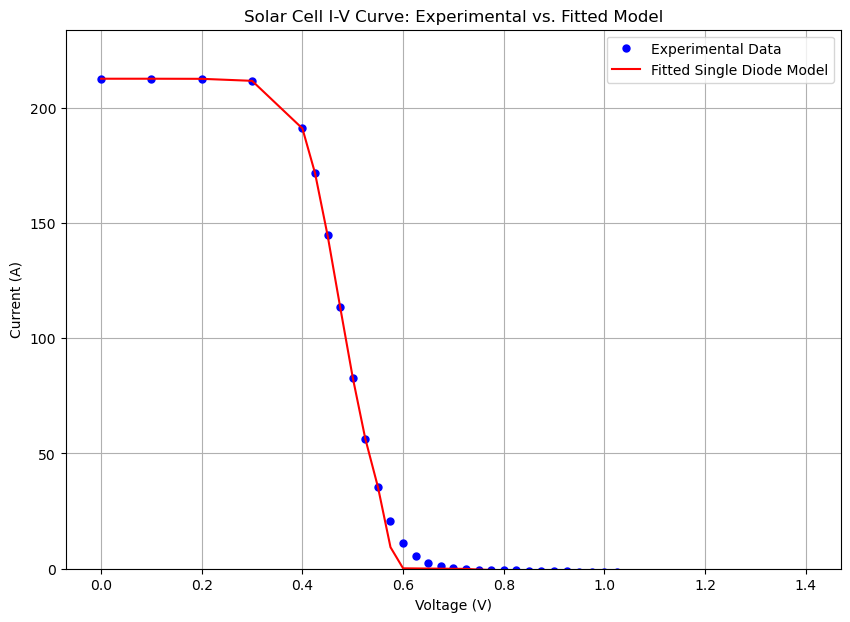


Root Mean Squared Error (RMSE): 2.5248e+00 A


In [37]:
I_exp = Output[0, :]
V_exp = Va

# Define bounds for curve_fit based on the measured short-circuit current
I_sc_approx = I_exp[0] # Isc is the first value in the I_exp array
bounds_for_fitting = (
    [0.5 * I_sc_approx, 1e-12, 0.8, 1e-4, 10],   # Lower bounds
    [1.5 * I_sc_approx, 1e-6, 2.5, 0.5, 5000]    # Upper bounds
)

model_to_fit = SingleDiodeModel(V_t, experimental_I_for_guesses=I_exp, param_bounds=bounds_for_fitting)

V_oc_idx = np.where(I_exp < 0.01 * I_sc_approx)[0]
V_oc_approx = V_exp[V_oc_idx[0]] if len(V_oc_idx) > 0 else 0.62
model_to_fit.V_oc_approx = V_oc_approx

p0 = [
    I_sc_approx,
    2e-9,
    1.4,
    0.05,
    300
]

# Ensure p0 is within bounds
for i in range(len(p0)):
    p0[i] = max(p0[i], bounds_for_fitting[0][i])
    p0[i] = min(p0[i], bounds_for_fitting[1][i])

print(f"\nInitial guesses (p0): {[f'{x:.2e}' for x in p0]}")
print(f"Parameter bounds (lower): {[f'{x:.2e}' for x in bounds_for_fitting[0]]}")
print(f"Parameter bounds (upper): {[f'{x:.2e}' for x in bounds_for_fitting[1]]}")

try:
    popt, pcov = curve_fit(
        model_to_fit, V_exp, I_exp, p0=p0, bounds=bounds_for_fitting, method='trf', max_nfev=5000,
    )
except (RuntimeError, ValueError) as e:
    print(f"\nError during curve_fit: {e}")
    print("Optimization failed. Check initial guesses, bounds, or data quality.")
else:
    I_ph_fit, I_0_fit, n_fit, R_s_fit, R_sh_fit = popt

    print("\n--- Extracted Parameters ---")
    print(f"I_ph (Photocurrent):     {I_ph_fit:.4f} A")
    print(f"I_0 (Saturation Current):{I_0_fit:.3e} A")
    print(f"n (Ideality Factor):     {n_fit:.3f}")
    print(f"R_s (Series Resistance): {R_s_fit:.4f} Ohms")
    print(f"R_sh (Shunt Resistance): {R_sh_fit:.2f} Ohms")

    I_fit = model_to_fit(V_exp, I_ph_fit, I_0_fit, n_fit, R_s_fit, R_sh_fit)

    plt.figure(figsize=(10, 7))
    plt.plot(V_exp, I_exp, 'bo', label='Experimental Data', markersize=5)
    if not np.any(np.isinf(I_fit)) and not np.any(np.isnan(I_fit)):
        plt.plot(V_exp, I_fit, 'r-', label='Fitted Single Diode Model')
    else:
        print("Fit resulted in Inf/NaN values, cannot plot fitted curve accurately.")

    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title('Solar Cell I-V Curve: Experimental vs. Fitted Model')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=max(0, np.min(I_exp)-0.1*I_sc_approx), 
             top=1.1*I_sc_approx)
    plt.show()

    if not np.any(np.isinf(I_fit)) and not np.any(np.isnan(I_fit)):
        rmse = np.sqrt(np.mean((I_exp - I_fit)**2))
        print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4e} A")
    else:
        print("\nCould not calculate RMSE due to invalid fitted current values.")


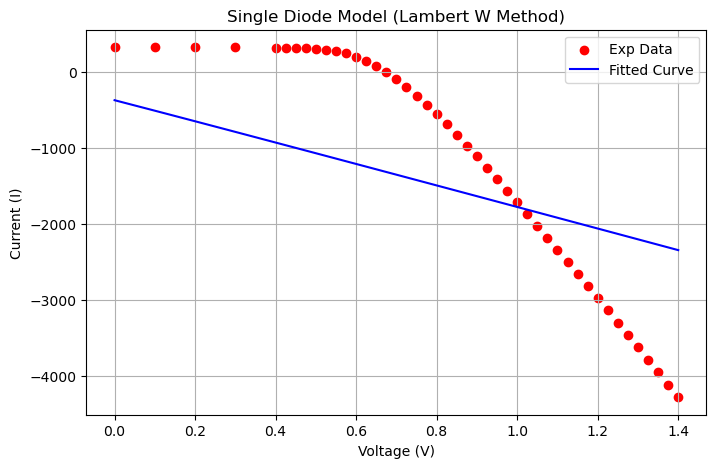

Optimized parameters: [1.62250300e+02 1.00000000e-06 8.00000000e-01 6.97315686e-04
 1.00000164e+01]


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.constants import k, e
from scipy.special import lambertw
import matplotlib.pyplot as plt

def single_diode_lambertw(V, I_ph, I_0, n, R_s, R_sh, T=298.15):
    V_t = n * k * T / e  # Thermal voltage
    argW = (I_ph + I_0) * R_sh * np.exp(
        (V + (I_ph + I_0) * R_s) / (n * V_t)
    ) / (I_0 * R_sh)
    I = (
        I_ph
        - n * V_t / R_s * lambertw(argW).real
        - (V + n * V_t * lambertw(argW).real) / R_sh
    )
    return I

# Parameter guesses and bounds
initial_guesses = [
    I_sc_approx,
    2e-9,
    1.4,
    0.05,
    300
]

bounds_for_fitting = (
    [0.5 * I_sc_approx, 1e-12, 0.8, 1e-4, 10],   # Lower bounds
    [1.5 * I_sc_approx, 1e-6, 2.5, 0.5, 5000]    # Upper bounds
)

# Fit
popt, _ = curve_fit(
    lambda V, I_ph, I_0, n, R_s, R_sh: single_diode_lambertw(V, I_ph, I_0, n, R_s, R_sh),
    V_exp, I_exp, p0=initial_guesses, bounds=bounds_for_fitting
)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(V_exp, I_exp, label='Exp Data', color='red')
plt.plot(V_exp, single_diode_lambertw(V_exp, *popt), label='Fitted Curve', color='blue')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.title('Single Diode Model (Lambert W Method)')
plt.legend()
plt.grid(True)
plt.show()

print("Optimized parameters:", popt)
